Import Libraries

In [1]:
import numpy as np                      # Data  
import pandas as pd                     # Data 
import matplotlib.pyplot as plt         # Plot
from  matplotlib.lines import Line2D
import matplotlib as mpl
from matplotlib.colors import LogNorm

Use Latex Font

In [2]:
plt.rcParams.update({
    "text.usetex": True,                # Use LaTeX for text
    "font.family": "serif",             # Use 'serif' font
    "font.serif": ["Computer Modern"],  # LaTeX default font
    "font.size": 11,                    # General font size
    "axes.labelsize": 11,               # Font size for labels
    "legend.fontsize": 11,              # Font size for legend
    "xtick.labelsize": 9,              # Font size for x-axis
    "ytick.labelsize": 9               # Font size for y-axis
})  

Import files

In [3]:
cf_wind = pd.read_csv('../Data/verification_cf_wind_1423.csv',
                      index_col = 0,
                      parse_dates = True
)

cf_wind.columns = 'EirGrid', 'Atlite', 'C3S-E N', 'C3S-E G'

## Verification metrics

In [4]:
# Define metrics
def calculate_metrics(reference, model):
    cc = np.corrcoef(reference, model)[0, 1]
    rmse = np.sqrt(np.mean((reference - model) ** 2))
    mbe = np.mean(model - reference)
    return np.round(cc, 3), np.round(rmse,3),  np.round(mbe,3)

In [5]:
metrics = {}
reference = cf_wind["EirGrid"]
models = ["Atlite", "C3S-E G", "C3S-E N"]

In [6]:
for model in models:
    metrics[model] = calculate_metrics(reference, cf_wind[model])

metrics_df = pd.DataFrame(metrics, index=["CC", "RMSE", "MBE"])

metrics_df

,Atlite,C3S-E G,C3S-E N
CC,NaN,NaN,NaN
RMSE,0.045,0.178,0.163
MBE,-0.003,0.139,0.122


# Plot

In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [8]:
cmap = truncate_colormap(mpl.colormaps['viridis'], maxval=0.2, minval=0.95)
cmap = cmap.resampled(6)
bins = np.arange(-0.025, 1.05, 0.05)
centered_bins = 0.5 * (bins[1:] + bins[:-1])

In [9]:
bounds = [1, 10, 100, 1000, 10000]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [10]:
models = {
    'Atlite': cf_wind['Atlite'].values,
    'C3S-E G': cf_wind['C3S-E G'].values,
    'C3S-E N': cf_wind['C3S-E N'].fillna(0.).values
}

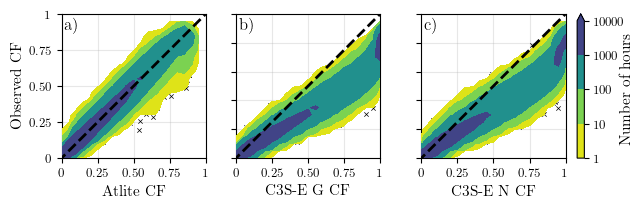

In [11]:
# cm / in ratio
cm = 1 / 2.54
fig, ax = plt.subplots(1, 3, 
                       figsize=(16 * cm, 5 * cm),
                       constrained_layout=True)

# Loop through models to create plots
for i, (label, model_data) in enumerate(models.items()):
    hist, _, _ = np.histogram2d(
        x=model_data,
        y=cf_wind['EirGrid'].values,
        bins=bins,
        density=False)
    # Scatter plot
    ax[i].scatter(
        x=model_data,
        y=cf_wind['EirGrid'].values,
        marker='x',
        c='k',
        s=10,
        lw=0.5,
        zorder=2)
    # Contour plot
    im = ax[i].contourf(
        centered_bins,
        centered_bins,
        hist.T,
        levels=bounds,
        cmap=cmap,
        norm=norm,
        extend='max',
        zorder=3)
    
    # Add diagonal line
    ax[i].plot(bins, bins, c='k', lw=2, ls='--', zorder=5)
    
    # Set axis properties
    ax[i].set_aspect(1.)
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(0, 1)
    ax[i].grid(alpha=0.3)
    ax[i].set_xlabel(f'{label} CF')

    ax[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax[0].set_yticklabels(['0', '0.25', '0.50', '0.75', '1'])
    ax[i].set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax[i].set_xticklabels(['0', '0.25', '0.50', '0.75', '1'])
    
    if i != 0:
        ax[i].set_yticklabels([])
    else:
        ax[i].set_ylabel('Observed CF')

    # Add subplot labels
    ax[i].text(0.02, 0.98, f'{chr(97 + i)})', fontsize=12, ha='left', va='top')

# Add color bar to the last subplot
cbar = fig.colorbar(im, ax=ax[2])
cbar.set_label('Number of hours', labelpad=-5)

# Save the figure
plt.savefig('verification_wind_contour.png', bbox_inches='tight', dpi=300)